# Machine Learning LAB 2: SUPPORT VECTOR MACHINES

Course 2023/24: *M. Caligiuri*, *P. Talli*, *F. Lincetto*, *F. Chiariotti*, *P. Zanuttigh*

The notebook contains some simple tasks to be performed with **SUPPORT VECTOR MACHINES (SVM)**.

Complete all the **required code sections** and **answer to all the questions**.

### IMPORTANT for the evaluation score:

1. **Read carefully all cells** and **follow the instructions**.
2. **Re-run all the code from the beginning** to obtain the results for the final version of your notebook, since this is the way we will do it before evaluating your notebooks.
3. Make sure to fill the code in the appropriate places **without modifying the template**, otherwise you risk breaking later cells.
4. Please **submit the jupyter notebook file (.ipynb)**, do not submit python scripts (.py) or plain text files. **Make sure that it runs fine with the restat&run all command**.
5. **Answer the questions in the appropriate cells**, not in the ones where the question is presented.

## Weather Classification with Support Vector Machines

In this notebook we are going to explore the use of Support Vector Machines (SVM) for weather classification. We will use a dataset collected using the Luxottica **iSee** glasses. These devices provide multiple **sensors mounted inside the glasses**, which can be accessed through a bluetooth connection.

![I-SEE Glasses](data/isee.png "I-SEE")

The dataset corresponds to 8 hours of atmospherical data recordings sampled every 3 seconds.

The dataset labels are the following:

| ID  | Label       |
| :-: | :-:         |
| 0   | Sunny       |
| 1   | Rain        |
| 2   | Cloudy      |
| 3   | Mostly Clear|

---

## Preliminary step

Place your **name** and **ID number** (matricola) in the cell below. <br>
Also recall to **save the file as Surname_Name_LAB02.ipynb**, failure to do so will incur in a **lower grade**.

**Student name**: Mario Rossi

**ID Number**: 1234567

---

## Import all the necessary Python libraries

In [1]:
%matplotlib inline

import numpy as np
import scipy as sp
import itertools
from matplotlib import pyplot as plt

import sklearn.metrics as skm
from sklearn.svm import SVC
from sklearn import linear_model

---

## Define the heplper functions

In this section you will find some helper functions (some already implemented, some to be implemented by you) that will be used in the following sections.
1. `load_dataset` -> to load the dataset from the file `data/lux.npz`,
2. `plot_input` -> to plot the input data,
3. `k_split` ->  to split the trainig dataset in k different folds,
4. `k_fold_cross_validation` -> to perform the k-fold cross validation.

**DO NOT CHANGE THE PRE-WRITTEN CODE UNLESS OTHERWISE SPECIFIED**

In [2]:
# Helper function to load the dataset
def load_dataset(path: str) -> (np.ndarray, np.ndarray):
    with np.load(path) as data:
        x, y = data["x"], data["y"]
        
        # Normalize the data
        x -= x.mean(axis=0)
        x /= x.std(axis=0)
        
    return x, y

In [3]:
# Function for plotting a image and printing the corresponding label
def plot_input(X_matrix: np.ndarray, labels: np.ndarray) -> None:
    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")
    cmap = plt.cm.get_cmap('Accent', 4)
    im = ax.scatter(X_matrix[:,0], X_matrix[:,1], X_matrix[:,2], c=labels, cmap=cmap)
    im.set_clim(-0.5, 3.5)
    cbar=fig.colorbar(im, ticks=[0,1,2,3], orientation='vertical', cmap=cmap)
    cbar.ax.set_yticklabels(['Sunny', 'Rainy','Cloudy', 'Mostly clear']) 

In [4]:
#controllo dimensioni del dataset 
X, label = load_dataset('/Users/giacomo/Desktop/POD/ML_POD/Homework_2/data/lux.npz')
print(X.shape)
print(X)

(15099, 3)
[[-0.21810122 -0.76123462  1.41896791]
 [-0.24687834 -0.58113616  1.40921664]
 [-0.24608631 -0.57576899  1.40495046]
 ...
 [-0.50296829  1.628648    0.14033258]
 [-0.50402433  1.63043706  0.13423803]
 [-0.50085621  1.63162976  0.14033258]]


In [5]:
# Function to split the dataset in k different folds
def k_split(x: np.ndarray, y:np.ndarray, k: int, shuffle: bool = True) -> tuple[list[np.ndarray], list[np.ndarray]]:
    # Shuffle the dataset
    if shuffle:
        # Create a list of indices
        idx = np.arange(x.shape[0])
        # Randomly shuffle the indices
        np.random.shuffle(idx)
        # Shuffle the dataset
        x = x[idx]
        y = y[idx]
    
    n = x.shape[0]
    fold_size = n // k

    #riempio la lista di k array numpy 
    x = [x[i:i + fold_size] for i in range(0, n, fold_size)]
    y = [y[i:i + fold_size] for i in range(0, n, fold_size)]

    return x, y

    # Split the dataset in k folds
    # ADD YOUR CODE HERE

In [6]:
# Function to perform the k-fold cross validation
def k_fold_cross_validation(x_train: np.ndarray, y_train: np.ndarray, k: int, model: SVC, parameters: dict) -> tuple[tuple, tuple]:
    # Define the folds for the cross validation
    x_folds, y_folds = k_split(x_train, y_train, k)

    # Build a list containing all of the possible combination of parameters
    params = list(itertools.product(*parameters.values()))

    # Initialize the dictionary of results
    results = {k: 0 for k in params}

    # For each param combination, perform the SVM training and testing
    for param in params:
        param = dict(zip(parameters.keys(), param))

        fold_accuracies = []
         #definisco il modello che vado ad utilizzare 
        #mod = SVC()
        mod = model
        for i in range(k):
            #vado ad iterare su tutti i fold, per ogni iterazione 
            # estraggo un fold che viene usato come test 
            x_folds_copy, y_folds_copy = x_folds.copy(), y_folds.copy() 
            
            x_fold_i = x_folds_copy.pop(i)
            y_fold_i = y_folds_copy.pop(i)
            x_train = np.concatenate(x_folds_copy)
            y_train = np.concatenate(y_folds_copy)

            #addestriamo il modello in base ai paramtetri nested 
            mod.set_params(**param)
            mod.fit(x_train, y_train)
            #valutiamo il modello
            accuracy = mod.score(x_fold_i, y_fold_i)
            fold_accuracies.append(accuracy)

        
        # ADD YOUR CODE HERE

        # Compute the mean accuracy
        results[tuple(param.values())] = round(np.mean(fold_accuracies), 4)
    
    # Find the best parameters
    best_parameters = dict(zip(parameters.keys(), params[np.argmax(list(results.values()))]))
    best_accuracy = np.max(list(results.values()))
    best = (best_parameters, best_accuracy)

    # Add the param name to the results
    results = [({k: v for k, v in zip(parameters.keys(), p)}, a) for p, a in results.items()]

    return best, results

---

## A) Hyper-parameter search

### TO DO (A.0)

**Set** the random **seed** using your **ID**. If you need to change it for testing add a constant explicitly, eg.: 1234567 + 1

In [7]:
# fix your ID ("numero di matricola") and the seed for random generator
# as usual you can try different seeds by adding a constant to the number:
# ID = 1234567 + X
ID = 2126898
np.random.seed(ID)

Before proceding to the training steps, we **load the dataset and split it** in training and test set (while the **training** set is **typically larger**, here we set the number of training samples to 1000 and 4000 for the test data).
The **split** is **performed after applying a random permutation** to the dataset, such permutation will **depend on the seed** you set above.

In [8]:
# Load the dataset using the helper function
X, y = load_dataset("/Users/giacomo/Desktop/POD/ML_POD/Homework_2/data/lux.npz")
print(X.shape, y.shape)

(15099, 3) (15099,)


In [9]:
# The task is quite easy, let's add noise to make it more challenging!
# You can try without noise (comment the next 2 lines, easy task), with the suggested amount of noise,
# or play with the suggested amount of noise 

noise = np.random.normal(0, 0.1, X.shape)
X = X + noise

### TO DO (A.1)

**Divide** the **data into training and test set** (for this part use 1000 samples in the **first** set, 4000 in the **second** one). Make sure that each label is present at least 10 times in training. If it is not, then keep adding permutations to the initial data until this happens.


In [10]:
# Random permute the data and split into training and test taking the first 1000
# data samples as training and 4000 samples as test
permutation = np.random.permutation(X.shape[0]) # ADD YOUR CODE HERE (replace None)

X = X[permutation] # ADD YOUR CODE HERE (replace None)
y = y[permutation] # ADD YOUR CODE HERE (replace None)

m_training = 1000
m_test = 4000

X_train = X[:m_training,:] # ADD YOUR CODE HERE (replace None)
X_test = X[m_training:m_training+m_test,:]# ADD YOUR CODE HERE (replace None)
y_train = y[:m_training] # ADD YOUR CODE HERE (replace None)
y_test = y[m_training:m_training+m_test] # ADD YOUR CODE HERE (replace None)

print("X_train shape:", X_train.shape,"X_test shape:", X_test.shape,"||","y_train shape:",  y_train.shape,"y_test shape:", y_test.shape)

labels, freqs = np.unique(y_train, return_counts = True) # ADD YOUR CODE HERE. Hint: use np.unique() (replace None)
print("Labels in training dataset: ", labels)
print("Frequencies in training dataset: ", freqs)

X_train shape: (1000, 3) X_test shape: (4000, 3) || y_train shape: (1000,) y_test shape: (4000,)
Labels in training dataset:  [0. 1. 2. 3.]
Frequencies in training dataset:  [373 202 361  64]


<ipython-input-3-bd4d18e1be0b>:8: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar=fig.colorbar(im, ticks=[0,1,2,3], orientation='vertical', cmap=cmap)


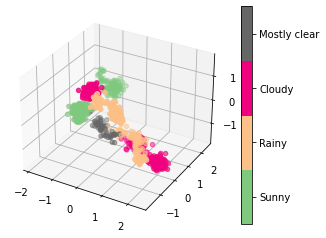

In [11]:
#Let's try the plotting function
plot_input(X_train,y_train)

### TO DO (A.2)

Use a SVM classfier with cross validation to pick a model. Use a 4-fold cross-validation. Let's start with a Linear kernel.

In [12]:
# Parameters for linear SVM
parameters = {'C': [ 0.01, 0.1, 1, 10]}

# Define the model (without parameters)
svm = SVC() # ADD YOUR CODE HERE (replace None)

# Perform the K-fold cross validation
best, results = k_fold_cross_validation(X_train, y_train, 4,  svm , parameters)

print ('RESULTS FOR LINEAR KERNEL')
print(results)

print("\nBest parameter set found:", best[0])
# ADD YOUR CODE HERE

print("\nScore with best parameter:", best[1])
# ADD YOUR CODE HERE
print()
print("All scores on the grid:")
# ADD YOU0R CODE HERE
for result in results:
    print(result)

RESULTS FOR LINEAR KERNEL
[({'C': 0.01}, 0.734), ({'C': 0.1}, 0.913), ({'C': 1}, 0.974), ({'C': 10}, 0.983)]

Best parameter set found: {'C': 10}

Score with best parameter: 0.983

All scores on the grid:
({'C': 0.01}, 0.734)
({'C': 0.1}, 0.913)
({'C': 1}, 0.974)
({'C': 10}, 0.983)


### TO DO (A.3)

Pick a model for the Polynomial kernel with degree=2.

In [13]:
# Parameters for linear SVM
parameters = {'C': [0.01, 0.1, 1],'gamma':[0.01,0.1,1.]}

# Define an SVM with poly of degree 2 kernel (without parameters)
poly2_svm = SVC(kernel='poly', degree= 2)  # ADD YOUR CODE HERE (replace None)

# Perform the K-fold cross validation
best, results = k_fold_cross_validation(X_train, y_train, 4,  poly2_svm , parameters) # ADD YOUR CODE HERE (replace None)

print ('RESULTS FOR POLY DEGREE=2 KERNEL')
print(results)

print("\nBest parameter set found:", best[0])
# ADD YOUR CODE HERE

print("\nScore with best parameter:", best[1])
# ADD YOUR CODE HERE
print()
print("All scores on the grid:")
# ADD YOUR CODE HERE
for result in results:
    print(result)

RESULTS FOR POLY DEGREE=2 KERNEL
[({'C': 0.01, 'gamma': 0.01}, 0.373), ({'C': 0.01, 'gamma': 0.1}, 0.373), ({'C': 0.01, 'gamma': 1.0}, 0.844), ({'C': 0.1, 'gamma': 0.01}, 0.373), ({'C': 0.1, 'gamma': 0.1}, 0.736), ({'C': 0.1, 'gamma': 1.0}, 0.93), ({'C': 1, 'gamma': 0.01}, 0.373), ({'C': 1, 'gamma': 0.1}, 0.844), ({'C': 1, 'gamma': 1.0}, 0.939)]

Best parameter set found: {'C': 1, 'gamma': 1.0}

Score with best parameter: 0.939

All scores on the grid:
({'C': 0.01, 'gamma': 0.01}, 0.373)
({'C': 0.01, 'gamma': 0.1}, 0.373)
({'C': 0.01, 'gamma': 1.0}, 0.844)
({'C': 0.1, 'gamma': 0.01}, 0.373)
({'C': 0.1, 'gamma': 0.1}, 0.736)
({'C': 0.1, 'gamma': 1.0}, 0.93)
({'C': 1, 'gamma': 0.01}, 0.373)
({'C': 1, 'gamma': 0.1}, 0.844)
({'C': 1, 'gamma': 1.0}, 0.939)


### TO DO (A.4)

Now let's try a higher degree for the polynomial kernel (e.g., 3rd degree).

In [14]:
# Parameters for poly with higher degree kernel
parameters = {'C': [0.01, 0.1, 1],'gamma':[0.01,0.1, 1]}

# Define an SVM with poly of higher degree kernel (without parameters)
degree = 3
poly_svm = SVC(kernel='poly', degree = degree) # ADD YOUR CODE HERE (replace None)

# Perform the K-fold cross validation
best, results = k_fold_cross_validation(X_train, y_train, 4,  poly_svm , parameters) # ADD YOUR CODE HERE (replace None)


print (f"RESULTS FOR POLY DEGREE={degree} KERNEL")
print(results)

print("\nBest parameter set found:", best[0])
# ADD YOUR CODE HERE

print("\nScore with best parameter:", best[1])
# ADD YOUR CODE HERE
print()
print("All scores on the grid:")
# ADD YOUR CODE HERE
for result in results:
    print(result)

RESULTS FOR POLY DEGREE=3 KERNEL
[({'C': 0.01, 'gamma': 0.01}, 0.341), ({'C': 0.01, 'gamma': 0.1}, 0.341), ({'C': 0.01, 'gamma': 1}, 0.836), ({'C': 0.1, 'gamma': 0.01}, 0.341), ({'C': 0.1, 'gamma': 0.1}, 0.511), ({'C': 0.1, 'gamma': 1}, 0.899), ({'C': 1, 'gamma': 0.01}, 0.341), ({'C': 1, 'gamma': 0.1}, 0.739), ({'C': 1, 'gamma': 1}, 0.906)]

Best parameter set found: {'C': 1, 'gamma': 1}

Score with best parameter: 0.906

All scores on the grid:
({'C': 0.01, 'gamma': 0.01}, 0.341)
({'C': 0.01, 'gamma': 0.1}, 0.341)
({'C': 0.01, 'gamma': 1}, 0.836)
({'C': 0.1, 'gamma': 0.01}, 0.341)
({'C': 0.1, 'gamma': 0.1}, 0.511)
({'C': 0.1, 'gamma': 1}, 0.899)
({'C': 1, 'gamma': 0.01}, 0.341)
({'C': 1, 'gamma': 0.1}, 0.739)
({'C': 1, 'gamma': 1}, 0.906)


### TO DO (A.5)

Pick a model for the Radial Basis Function kernel:

In [15]:
# Parameters for rbf SVM
parameters = {'C': [0.1, 1, 10, 100],'gamma':[0.001, 0.01, 0.1,1]}

# Define an SVM with rbf kernel (without parameters)
rbf_svm = SVC(kernel='rbf') # ADD YOUR CODE HERE (replace None)

# Perform the K-fold cross validation
best, results =  k_fold_cross_validation(X_train, y_train, 4,  rbf_svm , parameters) # ADD YOUR CODE HERE (replace None)

print ('RESULTS FOR rbf KERNEL')
print(results)

print("\nBest parameter set found:", best[0])
# ADD YOUR CODE HERE

print("\nScore with best parameter:", best[1])
# ADD YOUR CODE HERE
print()
print("All scores on the grid:")
# ADD YOUR CODE HERE
for result in results:
    print(result)

RESULTS FOR rbf KERNEL
[({'C': 0.1, 'gamma': 0.001}, 0.436), ({'C': 0.1, 'gamma': 0.01}, 0.584), ({'C': 0.1, 'gamma': 0.1}, 0.809), ({'C': 0.1, 'gamma': 1}, 0.961), ({'C': 1, 'gamma': 0.001}, 0.583), ({'C': 1, 'gamma': 0.01}, 0.771), ({'C': 1, 'gamma': 0.1}, 0.96), ({'C': 1, 'gamma': 1}, 0.985), ({'C': 10, 'gamma': 0.001}, 0.749), ({'C': 10, 'gamma': 0.01}, 0.891), ({'C': 10, 'gamma': 0.1}, 0.982), ({'C': 10, 'gamma': 1}, 0.983), ({'C': 100, 'gamma': 0.001}, 0.867), ({'C': 100, 'gamma': 0.01}, 0.971), ({'C': 100, 'gamma': 0.1}, 0.981), ({'C': 100, 'gamma': 1}, 0.983)]

Best parameter set found: {'C': 1, 'gamma': 1}

Score with best parameter: 0.985

All scores on the grid:
({'C': 0.1, 'gamma': 0.001}, 0.436)
({'C': 0.1, 'gamma': 0.01}, 0.584)
({'C': 0.1, 'gamma': 0.1}, 0.809)
({'C': 0.1, 'gamma': 1}, 0.961)
({'C': 1, 'gamma': 0.001}, 0.583)
({'C': 1, 'gamma': 0.01}, 0.771)
({'C': 1, 'gamma': 0.1}, 0.96)
({'C': 1, 'gamma': 1}, 0.985)
({'C': 10, 'gamma': 0.001}, 0.749)
({'C': 10, 'gamma'

### TO DO (A.Q1) [Answer the following]

What do you observe when using RBF and polynomial kernels on this dataset ?

**ANSWER A.Q1:**:

In general, on this dataset the linear kernel seems more accurate then the polinomial, the best results is given by the RBF kernel 

### TO DO (A.6)
Report here the best SVM kernel and parameters

In [16]:
# Get training and test error for the best SVM model from CV
#we use optimal paramters from the previus cell code 
best_svm, parameter = rbf_svm, best[0]  # USE YOUR OPTIMAL PARAMETERS HERE (replace None)

#addestriamo il modello in base ai paramtetri ottimali 
best_svm.set_params(**parameter)
best_svm.fit(X_train, y_train)

#valutiamo il modello
accuracy_train = best_svm.score(X_train, y_train)
accuracy_test = best_svm.score(X_test, y_test)
# Run the svm model on the whole training set

# Compute the errors
# (error is 1 - svm.score)
training_error = 1- accuracy_train# ADD YOUR CODE (replace None)
test_error = 1-accuracy_test # ADD YOUR CODE (replace None)

print ("Best SVM training error: %f" % training_error)
print ("Best SVM test error: %f" % test_error)

Best SVM training error: 0.016000
Best SVM test error: 0.011500


### TO DO (A.7)

Analyze how the gamma parameter (inversely proportional to standard deviation of Gaussian Kernel) impact the performances of the classifier

In [17]:
# Test with different values of gamma
# use rbf kernel and C=1

# Set gamma values
gamma_values = np.logspace(-5,5,8)
print(gamma_values)

[1.00000000e-05 2.68269580e-04 7.19685673e-03 1.93069773e-01
 5.17947468e+00 1.38949549e+02 3.72759372e+03 1.00000000e+05]


In [18]:
train_acc_list, test_acc_list = [], []

for gam in gamma_values:  
    model =  SVC(kernel='rbf', C=1, gamma = gam)  
    model.fit(X_train, y_train)
    #valutiamo il modello
    test_acc_list.append(model.score(X_test, y_test))
    train_acc_list.append(model.score(X_train, y_train))


for i in range(len(gamma_values)):
    print('\nGAMMA:', gamma_values[i])
    print('train acc:',train_acc_list[i])
    print('test acc:', test_acc_list[i])
# ADD YOUR CODE TO TRAIN THE SVM MULTIPLE TIMES WITH THE DIFFERENT VALUES OF GAMMA
# PLACE THE TRAIN AND TEST ACCURACY FOR EACH TEST IN THE TRAIN AND TEST ACCURACY LISTS


GAMMA: 1e-05
train acc: 0.373
test acc: 0.41675

GAMMA: 0.0002682695795279727
train acc: 0.469
test acc: 0.519

GAMMA: 0.0071968567300115215
train acc: 0.747
test acc: 0.78775

GAMMA: 0.19306977288832497
train acc: 0.976
test acc: 0.97925

GAMMA: 5.1794746792312125
train acc: 0.988
test acc: 0.9905

GAMMA: 138.9495494373139
train acc: 0.998
test acc: 0.9185

GAMMA: 3727.593720314938
train acc: 1.0
test acc: 0.4755

GAMMA: 100000.0
train acc: 1.0
test acc: 0.41725


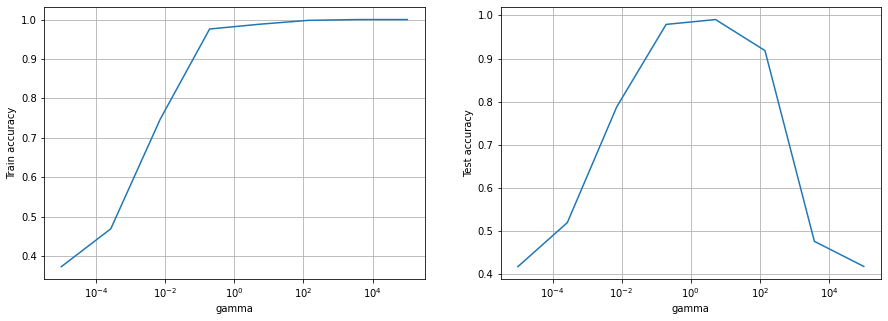

In [19]:
# Plot
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(gamma_values, train_acc_list)
ax[0].set_xscale('log')
ax[0].set_xlabel('gamma')
ax[0].set_ylabel('Train accuracy')
ax[0].grid(True)

ax[1].plot(gamma_values, test_acc_list)
ax[1].set_xscale('log')
ax[1].set_xlabel('gamma')
ax[1].set_ylabel('Test accuracy')
ax[1].grid(True)

plt.show()

## B) More data
Now let's do the same but using more data points for training.

### TO DO (B.0)

Choose a higher number of data points (e.g. x = 10000) for training data depending on your computing capability.

In [20]:
X = X[permutation]
y = y[permutation]

m_training = 11000 # ADD YOUR CODE: adjust depending on the capabilities of your PC (replace None)

X_train, X_test = X[:m_training], X[m_training:]
y_train, y_test = y[:m_training], y[m_training:]

labels, freqs = np.unique(y_train, return_counts = True) # ADD YOUR CODE (replace None)
print("Labels in training dataset: ", labels)
print("Frequencies in training dataset: ", freqs)

# initialize support variables for boundaries visualization
granularity = 25
x_max = np.abs(X).max()
x_range = np.linspace(-x_max, x_max, granularity)
x_grid = np.stack(np.meshgrid(x_range, x_range, x_range)).reshape(3, -1).T

Labels in training dataset:  [0. 1. 2. 3.]
Frequencies in training dataset:  [4459 1858 4034  649]


### TO DO (B.1)

Let's try to use SVM with parameters obtained from the best model for $m_{training} =  10000$. Since it may take a long time to run, you can decide to just let it run for some time and stop it if it does not complete. If you decide to do this, report it in the TO DO (C.Q1) cell below.

In [21]:
# Parameters for linear SVM
parameters = {'C': [ 0.01, 0.1, 1, 10]}

# Define the model (without parameters)
svm = SVC() # ADD YOUR CODE HERE (replace None)

# Perform the K-fold cross validation
best, results = k_fold_cross_validation(X_train, y_train, 4,  svm , parameters)

print ('RESULTS FOR LINEAR KERNEL---------------------------------------------------------------------------------------------------------------')
print(results)

print("Best parameter set found:", best[0])
# ADD YOUR CODE HERE

print("Score with best parameter:", best[1])
# ADD YOUR CODE HERE
print()
print("All scores on the grid:")
# ADD YOU0R CODE HERE
for result in results:
    print(result)




# Parameters for linear SVM
parameters = {'C': [0.01, 0.1, 1],'gamma':[0.01,0.1,1.]}

# Define an SVM with poly of degree 2 kernel (without parameters)
poly2_svm = SVC(kernel='poly', degree= 2)  # ADD YOUR CODE HERE (replace None)

# Perform the K-fold cross validation
best, results = k_fold_cross_validation(X_train, y_train, 4,  poly2_svm , parameters) # ADD YOUR CODE HERE (replace None)

print ('\nRESULTS FOR POLY DEGREE=2 KERNEL------------------------------------------------------------------------------------------------------')
print(results)

print("Best parameter set found:", best[0])
# ADD YOUR CODE HERE

print("Score with best parameter:", best[1])
# ADD YOUR CODE HERE
print()
print("All scores on the grid:")
# ADD YOUR CODE HERE
for result in results:
    print(result)



# Parameters for poly with higher degree kernel
parameters = {'C': [0.01, 0.1, 1],'gamma':[0.01,0.1, 1]}

# Define an SVM with poly of higher degree kernel (without parameters)
degree = 3
poly_svm = SVC(kernel='poly', degree = degree) # ADD YOUR CODE HERE (replace None)

# Perform the K-fold cross validation
best, results = k_fold_cross_validation(X_train, y_train, 4,  poly_svm , parameters) # ADD YOUR CODE HERE (replace None)


print (f"\nRESULTS FOR POLY DEGREE={degree} KERNEL----------------------------------------------------------------------------------------------")
print(results)

print("Best parameter set found:", best[0])
# ADD YOUR CODE HERE

print("Score with best parameter:", best[1])
# ADD YOUR CODE HERE
print()
print("All scores on the grid:")
# ADD YOUR CODE HERE
for result in results:
    print(result)



# Parameters for rbf SVM
parameters = {'C': [0.1, 1, 10, 100],'gamma':[0.001, 0.01, 0.1,1]}

# Define an SVM with rbf kernel (without parameters)
rbf_svm = SVC(kernel='rbf') # ADD YOUR CODE HERE (replace None)

# Perform the K-fold cross validation
best, results =  k_fold_cross_validation(X_train, y_train, 4,  rbf_svm , parameters) # ADD YOUR CODE HERE (replace None)

print ('\nRESULTS FOR rbf KERNEL----------------------------------------------------------------------------------------------------------------')
print(results)

print("Best parameter set found:", best[0])
# ADD YOUR CODE HERE

print("Score with best parameter:", best[1])
# ADD YOUR CODE HERE
print()
print("All scores on the grid:")
# ADD YOUR CODE HERE
for result in results:
    print(result)

RESULTS FOR LINEAR KERNEL---------------------------------------------------------------------------------------------------------------
[({'C': 0.01}, 0.9042), ({'C': 0.1}, 0.9786), ({'C': 1}, 0.986), ({'C': 10}, 0.9877)]
Best parameter set found: {'C': 10}
Score with best parameter: 0.9877

All scores on the grid:
({'C': 0.01}, 0.9042)
({'C': 0.1}, 0.9786)
({'C': 1}, 0.986)
({'C': 10}, 0.9877)

RESULTS FOR POLY DEGREE=2 KERNEL------------------------------------------------------------------------------------------------------
[({'C': 0.01, 'gamma': 0.01}, 0.4054), ({'C': 0.01, 'gamma': 0.1}, 0.7709), ({'C': 0.01, 'gamma': 1.0}, 0.9353), ({'C': 0.1, 'gamma': 0.01}, 0.4054), ({'C': 0.1, 'gamma': 0.1}, 0.8504), ({'C': 0.1, 'gamma': 1.0}, 0.9434), ({'C': 1, 'gamma': 0.01}, 0.7709), ({'C': 1, 'gamma': 0.1}, 0.9353), ({'C': 1, 'gamma': 1.0}, 0.9439)]
Best parameter set found: {'C': 1, 'gamma': 1.0}
Score with best parameter: 0.9439

All scores on the grid:
({'C': 0.01, 'gamma': 0.01}, 0.4

In [22]:
# Get training and test error for the best SVM model from CV
best_svm, parameter = rbf_svm, best[0]  # USE YOUR OPTIMAL PARAMETERS HERE (replace None)

#addestriamo il modello in base ai paramtetri ottimali 
best_svm.set_params(**parameter)
best_svm.fit(X_train, y_train)

#valutiamo il modello
accuracy_train = best_svm.score(X_train, y_train)
accuracy_test = best_svm.score(X_test, y_test)
# Run the svm model on the whole training set

# Compute the errors
# (error is 1 - svm.score)
training_error = 1- accuracy_train# ADD YOUR CODE (replace None)
test_error = 1-accuracy_test # ADD YOUR CODE (replace None)

# ADD YOUR CODE

print ("Best SVM training error: %f" % training_error)
print ("Best SVM test error: %f" % test_error)

Best SVM training error: 0.010727
Best SVM test error: 0.008051


## C) Boundaries Visualization

Now let us plot the classification boundaries. 

### TO DO (C.0)

Use the SVM to predict on the test set X_test. 

In [23]:
rbf_svm_test = best_svm.predict(X_test) # ADD YOUR CODE (replace None)

We constructed a grid of all possible combinations of input values, we now use it to extract the classification boundaries of the three classifiers by having them predict on each input.

(-2.6726677797733345, 2.6726677797733345)

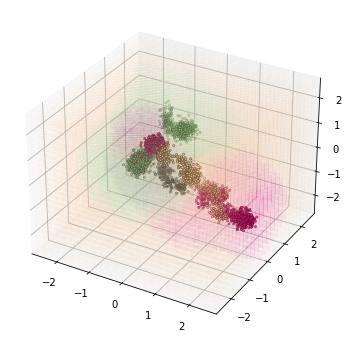

In [24]:
rbf_SVM_grid = rbf_svm.predict(x_grid)

rbf_SVM_m = y_test == rbf_svm_test

fig = plt.figure(figsize=(20,36))
ax1 = fig.add_subplot(1, 3, 1, projection="3d")
#ax2 = fig.add_subplot(1, 3, 2, projection="3d")
#ax3 = fig.add_subplot(1, 3, 3, projection="3d")

ax1.scatter(x_grid[:,0], x_grid[:,1], x_grid[:,2], c=rbf_SVM_grid, linewidth=0, marker="s", alpha=.05,cmap='Accent')

ax1.scatter(X_test[rbf_SVM_m,0], X_test[rbf_SVM_m,1], X_test[rbf_SVM_m,2], c=y_test[rbf_SVM_m], linewidth=.5, edgecolor="k", marker=".",cmap='Accent')
ax1.scatter(X_test[~rbf_SVM_m,0], X_test[~rbf_SVM_m,1], X_test[~rbf_SVM_m,2], c=y_test[~rbf_SVM_m], linewidth=1, edgecolor="r", marker=".",cmap='Accent')
ax1.set_xlim([-x_max, x_max])
ax1.set_ylim([-x_max, x_max])
ax1.set_zlim([-x_max, x_max])

### TO DO (C.Q1) [Answer the following]**

Compare and discuss the results from SVM with m=600 and with m=10000 (or whatever value you set) training data points. If you stopped the SVM, include such aspect in your comparison.

**ANSWER C.Q1:** Answer here

The results on iperparameters doesn't change a lot, the best kernel remain the SVC with rbf kernel.
Adding more samples in the training set the error is decreasing as we expecting.

### TO DO (C.1)

Plot the confusion matrix for the SVM classifier. The confusion matrix has one column for each predicted label and one row for each true label. 
It shows for each class in the corresponding row how many samples belonging to that class gets each possible output label. Notice that the diagonal contains the correctly classified samples, while the other cells correspond to errors. You can obtain it with the sklearn.metrics.confusion_matrix function (see the documentation). You can also print also the normalized confusion matrix.


In [25]:
from sklearn.metrics import confusion_matrix
np.set_printoptions(precision=2, suppress=True) # for better aligned printing of confusion matrix use floatmode='fixed'

u, counts = np.unique(y_test, return_counts=True)
print("Labels and frequencies in test set: ", counts)

confusion_SVM =  confusion_matrix(y_test, rbf_svm_test)# ADD YOUR CODE
print("\n Confusion matrix SVM  \n \n", confusion_SVM)
print("\n Confusion matrix SVM (normalized)   \n \n", confusion_SVM /counts[:,None] )

Labels and frequencies in test set:  [1659  670 1489  281]

 Confusion matrix SVM  
 
 [[1659    0    0    0]
 [   0  645   25    0]
 [   0    7 1482    0]
 [   0    1    0  280]]

 Confusion matrix SVM (normalized)   
 
 [[1.   0.   0.   0.  ]
 [0.   0.96 0.04 0.  ]
 [0.   0.   1.   0.  ]
 [0.   0.   0.   1.  ]]


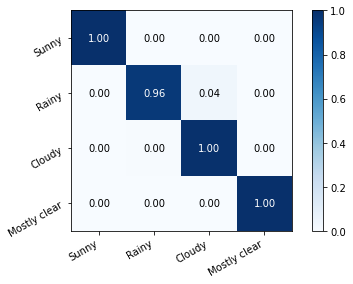

In [26]:
fig = plt.figure()    
im = plt.imshow(confusion_SVM /counts[:,None], cmap="Blues",interpolation='nearest')
plt.xticks([0,1,2,3], ['Sunny', 'Rainy','Cloudy', 'Mostly clear'],ha="right",rotation=30)
plt.yticks([0,1,2,3], ['Sunny', 'Rainy','Cloudy', 'Mostly clear'],ha="right",rotation=30)
cm = confusion_SVM /counts[:,None]
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], fmt),
        ha="center", va="center",
        color="white" if cm[i, j] > thresh else "black")

fig.tight_layout()
fig.colorbar(im)  
plt.show()

### TO DO (C.Q2) [Answer the following]

Have a look at the confusion matrix and comment on the obtained accuracies. Why some classes have lower accuracies and others an higher one? Make some guesses on the possible causes.

**ANSWER C.Q2:** Answer here


The confusion matrix reveals almost a 'perfect score' for class 0 and 3 (Sunny, Mostly Clear). However, the model struggles with classes 1 and 2 (Rainy, Cloudy),  misclassifying some examples between these two categories. This confusion is probably due to the subtle distinction between Rainy and Cloudy conditions. These weather types have a fine line of demarcation and can overlap, as they originate from similar meteorological parameters.